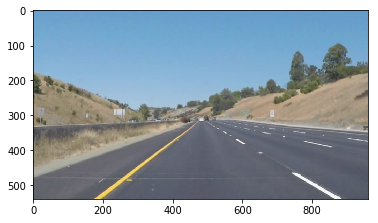

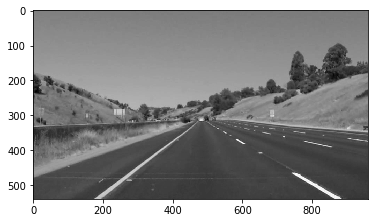

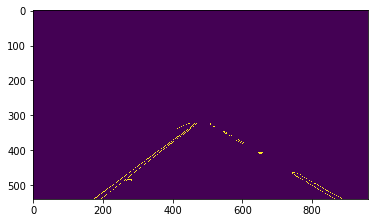

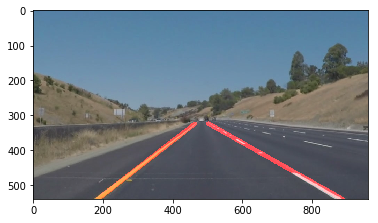

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
imshape = image.shape
#printing out some stats and plotting
plt.imshow(image)
plt.show()
plt.imshow(grayscale(image), cmap='gray')
plt.show()
# definig x,y boundaries of our region of ineterst
#bottom Y coordinate
by= imshape[0]
#top Y coordinate
ty=int(math.floor(imshape[0]*.6))
#left x coordinate
lx= int(math.floor(imshape[1]*.15))
#right x coordinate
rx= int(math.floor(imshape[1]*.95))
#top left x coordinate
tlx= int(math.floor(imshape[1]*.45))
#top right x coordinate
trx= int(math.floor(imshape[1]*.55))
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    #print(masked_image.shape)
    return masked_image
#function to identify two lane lines from the current frame detected lines data using hough transform
def two_lines (lines):
    global oldleftline
    global oldrightline
    leftline = []
    rightline = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            #calculating line equation with in the form of x = my + c
            #i did not use y = mx + c becuase there is a possibility that lane line is perpendicular to x axis therefore m will be infinite
            if (y1==y2):
                continue
            m=((x2 - x1)/(y2-y1))
            c=(x2-(m*y2))
            #coordinates of intersection of this line with bottom and top boundary
            lnbx = int(math.floor((m*by) + c))
            lntx = int(math.floor((m*ty) + c))
            # removing noise excluding lines which are out of defined region
            if ((lnbx < lx) or (lnbx > rx) or (lntx < tlx) or (lntx > trx)):
                continue
            #checking if line is left line or right line
            if (lnbx < tlx):
                leftline.append([lnbx,by,lntx,ty])
            else:
                rightline.append([lnbx,by,lntx,ty])
    # taking median of all the lane lines detected, if lines not detected on one of the sides then old value will be taken
    leftlineends=(np.median(np.asarray(leftline,dtype=np.int64),axis=0).astype(np.int64))
    rightlineends= (np.median(np.asarray(rightline,dtype=np.int64),axis=0).astype(np.int64))
    return np.stack((leftlineends,rightlineends)) 

def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  

    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        #for x1,y1,x2,y2 in line:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)
        #cv2.line(img, (x1,y1),(x2,y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines2 = two_lines(lines)
    draw_lines(line_img, lines2)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
vertices = np.array([[(lx,by),(tlx, ty), (trx, ty), (rx,by)]], dtype=np.int32)
#print(vertices)
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on
region1=region_of_interest(canny(gaussian_blur(grayscale(image),3), 50, 150),vertices)
plt.imshow(region1)
plt.show()
img2=weighted_img(hough_lines(region1, rho, theta, threshold, min_line_len, max_line_gap), image)
plt.imshow(img2)
plt.show()